In [1]:
from comet_ml import API
import comet_ml
import io
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
import time
sns.set(context='paper', style="whitegrid", font_scale=2)
colors = ["g", "b", "r", "y", "m",  "c", "tab:brown", ""]
colors = [
    '#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#42d4f4', 
    'grey', '#469990', 'black', '#9A6324', '#fffac8', '#800000', 
    '#aaffc3', '#000075', '#a9a9a9', '#000000'
]
%matplotlib inline
linewidth = 3

comet_api = API()
comet_api.get()

def get_parameter_by_key(exp, key):
    parameters = exp.get_parameters_summary()
    for parameter in parameters:
        if parameter['name'] == key:
            return parameter['valueCurrent']
    return None

## Optimal clustering values

threshold = 0.6

min_samples_core = 4

In [2]:
command_to_run = "sbatch -c 1 -t 720 --gpus=0 run_clustering.sh --key {} --num_layers_edge_conv 5 --num_layers_emulsion 3 -cl_size 40 --min_cl 40 --threshold {:.2f} --min_samples_core {}"

In [3]:
num_epochs = 200

experiments = comet_api.get(workspace='schattengenie', project_name='em-showers-network-training')
experiments = [
    exp for exp in experiments
    if (time.time() - exp.end_server_timestamp / 1000) / 60 / 60 < 48
]
experiments = [
    exp for exp in experiments
    if get_parameter_by_key(exp, "num_layers_edge_conv") == '5'
]

In [4]:
np.set_printoptions(precision=1, suppress=True)

In [5]:
commands_to_run = []
for threshold in np.linspace(-2, 2, 11) + 0.6:
    for min_samples_core in [0, 2, 4, 6, 8]:
        for exp in experiments:
            print(threshold)
            commands_to_run.append(command_to_run.format(exp.get_metadata()["experimentKey"], threshold, min_samples_core))

In [6]:
for c in commands_to_run:
    print(c)
    pass

In [7]:
len(commands_to_run)

0

## Sensitivity analysis

In [8]:
def get_parameter_by_key(exp, key):
    parameters = exp.get_parameters_summary()
    for parameter in parameters:
        if parameter['name'] == key:
            return parameter['valueCurrent']
    return None

def new_to_old_metric(exp, key):
    metric = exp.get_metrics(key)
    vals = [float(m['metricValue']) for m in metric]
    return vals

def stack_lists(data, n=1000):
    new_data = []
    for d in data:
        if len(d) > n:
            new_data.append(d[:n])
        elif len(d) < n:
            new_data.append(
                np.concatenate([d, d[-1].repeat(n - len(d))])
            )
    return np.vstack(new_data).T

def preprocess_gp(vals):
    return np.minimum.accumulate(vals)

def add_zero_point(vals, point):
    return np.array([point] + vals.tolist())

In [9]:
experiments = comet_api.get(workspace='schattengenie', project_name='em-showers-network-clustering-new')

In [10]:
exp = experiments[0]

In [11]:
from collections import defaultdict

data = defaultdict(lambda: defaultdict(list))
for exp in experiments:
    good_showers = new_to_old_metric(exp, "Good showers")
    if len(good_showers):
        threshold = float(exp.get_command()[-5])
        min_samples_core = int(get_parameter_by_key(exp, "min_samples_core"))
        data[threshold][min_samples_core].append(good_showers[0])

In [12]:
threshold_data = defaultdict(list)
quality_data = defaultdict(list)
quality_std_data = defaultdict(list)

for threshold in data:
    for min_samples_core in data[threshold]:
        q = data[threshold][min_samples_core]
        threshold_data[min_samples_core].append(threshold)
        quality_data[min_samples_core].append(np.mean(q))
        quality_std_data[min_samples_core].append(np.std(q))

In [13]:
def plot_mean_std(idx, mean, std, label="", i=0):
    idx = np.array(idx)
    mean = np.array(mean)
    std = np.array(std)
    upper = mean + std
    lower = mean - std
    plt.plot(idx, mean, c=colors[i], linewidth=linewidth, label=label, zorder=5)
    plt.plot(idx, upper, 'b--', c=colors[i], zorder=5)
    plt.plot(idx, lower, 'b--', c=colors[i], zorder=5)
    plt.fill_between(idx, lower, upper, alpha=0.2, color=colors[i], zorder=5)

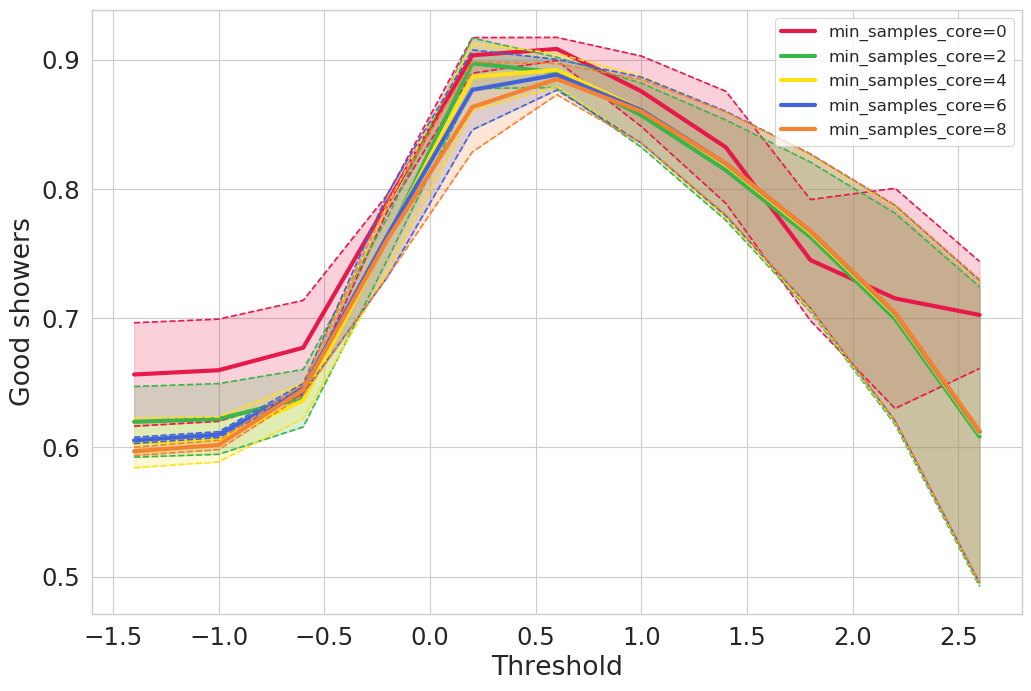

In [14]:
plt.figure(figsize=(12, 8), dpi=100)
plt.title("")
for i, min_samples_core in enumerate(threshold_data):
    plot_mean_std(threshold_data[min_samples_core], quality_data[min_samples_core], 
                  quality_std_data[min_samples_core], label="min_samples_core={}".format(min_samples_core), i=i)
plt.ylabel("Good showers")
plt.xlabel("Threshold")
# plt.ylim
plt.legend(loc='upper right', fontsize='large')
plt.savefig("threshold_grid_search_plot.pdf", bbox_inches='tight')
plt.show()